   X_mean  Y_mean  Z_mean  theta_true  phi_true    X_true    Y_true    Z_true  \
0    0.60    0.25    0.20    1.197482  0.338167  0.878389  0.308909  0.364704   
1    0.42    0.51   -0.56    2.400494  0.950751  0.392281  0.549430 -0.737727   
2    0.96    0.30   -0.19    1.853539  0.218332  0.937497  0.208001 -0.278990   
3    0.04    0.10   -0.69    3.036265  1.807761 -0.024680  0.102195 -0.994458   
4   -0.79    0.36   -0.49    2.095058  2.617071 -0.749313  0.433539 -0.500574   

      X_mle     Y_mle     Z_mle  theta_mle   phi_mle  
0  0.600000  0.250000  0.200000   1.369438  0.394791  
1  0.420000  0.510000 -0.560000   2.165182  0.881872  
2  0.937892  0.293091 -0.185624   1.757504  0.302885  
3  0.040000  0.100000 -0.690000   2.332285  1.190290  
4 -0.790000  0.360000 -0.490000   2.082886  2.714012  

Description statistique des colonnes numériques :
            X_mean       Y_mean       Z_mean   theta_true     phi_true  \
count  4849.000000  4848.000000  4853.000000  5000.000000 

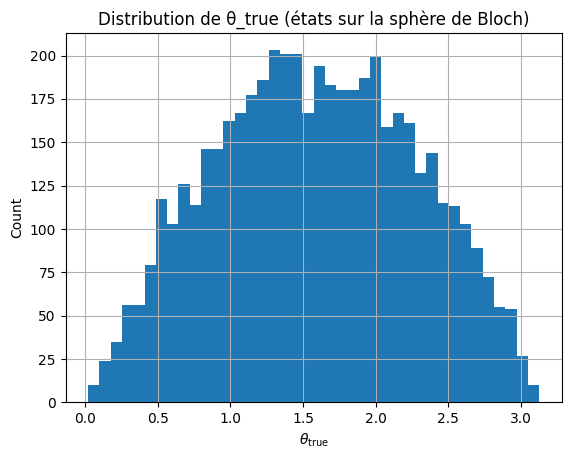

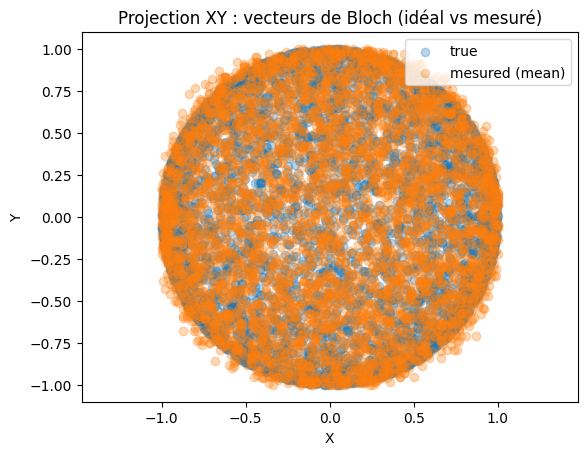

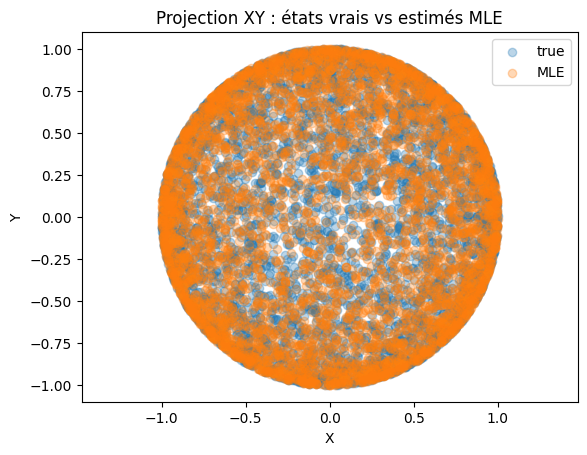

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#importer la fonction de création de dataset : 
from dataset_build.saint_dtSet import generate_qubit_tomography_dataset

# 1) Générer un dataset de test
df = generate_qubit_tomography_dataset(
    n_states=5000,
    n_shots=200,
    mode="finite_shots",
    include_ideal=True,
    include_mle=True,
    include_decoherence=True,    # ici test avec la décohérence, donc normal qu'y ait des Nan!
    decoherence_level=0.3,
    random_state=123,
)

# 2) Afficher les premières lignes
print(df.head())

# 3) Quelques stats globales
print("\nDescription statistique des colonnes numériques :")
print(df.describe())

# 4) Plot de la distribution de θ_true (si include_ideal=True)
plt.figure()
df["theta_true"].hist(bins=40)
plt.xlabel(r"$\theta_{\mathrm{true}}$")
plt.ylabel("Count")
plt.title("Distribution de θ_true (états sur la sphère de Bloch)")
plt.show()

# 5) Scatter du vecteur de Bloch idéal vs bruité (projection XY)
plt.figure()
plt.scatter(df["X_true"], df["Y_true"], alpha=0.3, label="true")
plt.scatter(df["X_mean"], df["Y_mean"], alpha=0.3, label="mesured (mean)")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Projection XY : vecteurs de Bloch (idéal vs mesuré)")
plt.legend()
plt.axis("equal")
plt.show()

# 6) Scatter des points MLE vs true sur la sphère (XY)
#    On filtre les lignes où la MLE n'est pas NaN
mask_valid_mle = df["theta_mle"].notna() & df["phi_mle"].notna()
df_valid = df[mask_valid_mle].copy()

X_mle_bloch = np.sin(df_valid["theta_mle"]) * np.cos(df_valid["phi_mle"])
Y_mle_bloch = np.sin(df_valid["theta_mle"]) * np.sin(df_valid["phi_mle"])

plt.figure()
plt.scatter(df_valid["X_true"], df_valid["Y_true"], alpha=0.3, label="true")
plt.scatter(X_mle_bloch, Y_mle_bloch, alpha=0.3, label="MLE")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Projection XY : états vrais vs estimés MLE")
plt.legend()
plt.axis("equal")
plt.show()


In [5]:
# test_classification

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1) Générer un petit dataset pour la classification
df_clf = generate_qubit_tomography_dataset(
    n_states=2000,
    n_shots=50,                 # peu de shots -> bruit plus fort
    mode="finite_shots",
    include_ideal=True,         # on a besoin de Z_true pour construire les labels
    include_mle=False,          # pas nécessaire pour ce test
    include_decoherence=False,  # on coupe la décohérence pour commencer simple
    random_state=42,
)

# 2) Définir une target binaire à partir de Z_true :
#    1 si état dans l'hémisphère nord (Z_true >= 0), 0 sinon
df_clf["label"] = (df_clf["Z_true"] >= 0).astype(int)

# 3) Features : les moyennes mesurées
X = df_clf[["X_mean", "Y_mean", "Z_mean"]].values
y = df_clf["label"].values

# (Optionnel) si tu autorises des NaN plus tard (décohérence + missing),
# il faudra filtrer ici :
# mask = ~np.isnan(X).any(axis=1)
# X = X[mask]
# y = y[mask]

# 4) Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

# 5) Création et entraînement du modèle SVC
clf = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=0)
clf.fit(X_train, y_train)

# 6) Prédiction et évaluation
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy SVC : {acc:.3f}")
print("Matrice de confusion :")
print(cm)
print("\nClassification report :")
print(classification_report(y_test, y_pred))


Accuracy SVC : 0.940
Matrice de confusion :
[[298  13]
 [ 23 266]]

Classification report :
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       311
           1       0.95      0.92      0.94       289

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600

